<a href="https://www.kaggle.com/code/bilelhaddad/emotion-detection-using-fine-tuned-bert?scriptVersionId=211625108" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Importing all the necessary libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # df processing, CSV file I/O (e.g. pd.read_csv)

# Input df files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotion-from-emogo/emotion_preprocessed.csv
/kaggle/input/emotions-dataset-for-nlp/val.txt
/kaggle/input/emotions-dataset-for-nlp/test.txt
/kaggle/input/emotions-dataset-for-nlp/train.txt
/kaggle/input/emotion-recognition-using-bert/__results__.html
/kaggle/input/emotion-recognition-using-bert/__notebook__.ipynb
/kaggle/input/emotion-recognition-using-bert/__output__.json
/kaggle/input/emotion-recognition-using-bert/custom.css


In [2]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
 
# remove digits and special characters
def remove_digits(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    #when the ^ is on the inside of []; we are matching any character that is not included in this expression within the []
    return re.sub(pattern, '', text)

def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
df_filtered = pd.read_csv('/kaggle/input/emotion-from-emogo/emotion_preprocessed.csv')
df_filtered.sample(2)
#df_filtered['cleanText_NoPunct'] = df_filtered['cleanText'].apply(remove_punct)

,text,category,cleanText,label,num_words
31500,How many is that now? Feels like the 4th one now,neutral,how now? feels th one,6,11
28598,Mine is entirely too interested in any and all...,neutral,mine entirely interested candlerelated mitzvot...,6,25


In [4]:
!pip install transformers 

In [5]:
from helper_prabowo_ml import clean_html, remove_links, non_ascii, lower, email_address, removeStopWords, punct, remove_, remove_special_characters, remove_digits
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def preprocess(text):
    """function to perform pre-processing lowercasing,removing special characters,keeping only important anonym tokens etc.. 
    text:str
    return:str
    """
    #Select english StopWords
    cachedStopWords = set(stopwords.words("english"))
    #add custom words
    cachedStopWords.update(('and','I','A','http','And','So','arnt','This','When','It','many','Many','so','cant','Yes','yes','No','no','These','these','mailto','regards','ayanna','like','email'))
    #remove stop words
    new_str = ' '.join([word for word in text.split() if word not in cachedStopWords]) 
    email = re.compile(r'[\w\.-]+@[\w\.-]+')
    links = re.compile(r'http')
    new_str = email.sub(r'',new_str)
    new_str = links.sub(r'',new_str)
    new_str = re.sub(r'\[.*?\]', '', new_str)
    new_str = re.sub(r'http\S+', '', new_str) # remove http links
    new_str = re.sub(r'bit.ly/\S+', '',new_str) #remove bit.ly links
    html = re.compile('<.*?>')
    new_str = html.sub(r'',new_str)
    new_str = remove_digits(new_str)
    new_str = remove_special_characters(new_str)
    new_str = new_str.lower()#lowercasing the text
    new_str = new_str.replace("  "," ")
    return new_str

## Combining the train, validation and test datasets into a single dataframe

In [30]:
df_filtered['num_words'] = df_filtered.text.apply(len)
df_filtered['cleanWords'] = df_filtered['cleanText'].apply(len)

In [31]:
df_filtered.head()

,text,category,cleanText,label,num_words,cleanWords
0,That game hurt.,sadness,that game hurt.,4,15,15
1,"You do right, if you don't care then fuck 'em!",neutral,"you right, care fuck 'em!",6,46,25
2,"[NAME] was nowhere near them, he was by the Fa...",neutral,"nowhere near them, falcon.",6,52,27
3,"I have, and now that you mention it, I think t...",neutral,"have, mention it, think that's triggered nosta...",6,81,51
4,BUT IT'S HER TURN! /s,neutral,but it's her turn! /s,6,21,21


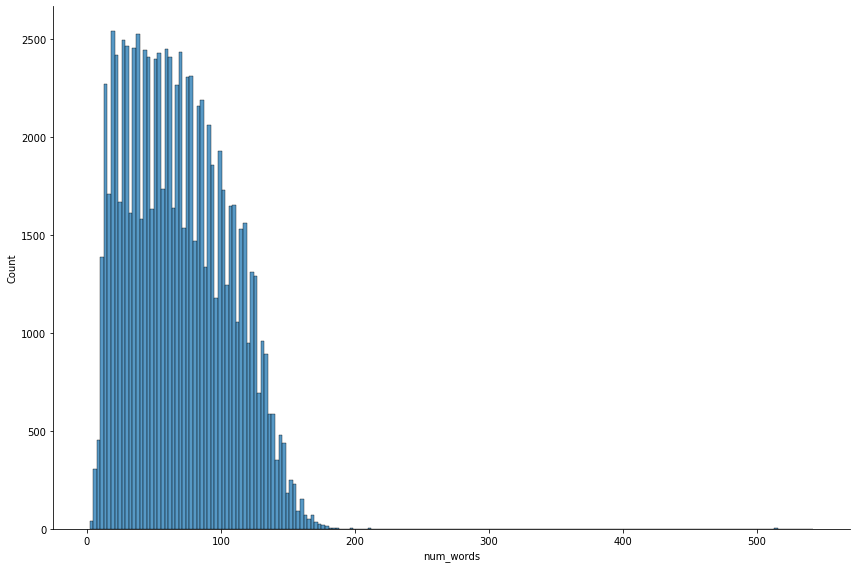

In [32]:
sns.displot(df_filtered.num_words,height=8,aspect=1.5)

In [10]:
#encoded_labels = {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5} 

In [33]:
encoded_labels = {
    'anger': 0,
    'disgust': 1,
    'fear': 2,
    'happiness': 3,
    'sadness': 4,
    'surprise': 5,
    'neutral': 6
}
enc2label = {v:k for k,v in encoded_labels.items()}
enc2label

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'happiness',
 4: 'sadness',
 5: 'surprise',
 6: 'neutral'}

## Train-Test Split

In [34]:
#Drop Nan Values First
df_filtered.dropna(inplace=True)
df_filtered.to_csv('clean_df.csv',index=False)

In [35]:
train_data, test_data = train_test_split(df_filtered,test_size=0.3,random_state=101,shuffle=True,stratify=df_filtered.label)

## Loading the Tokenizer class and pretrained BERT model

In [36]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


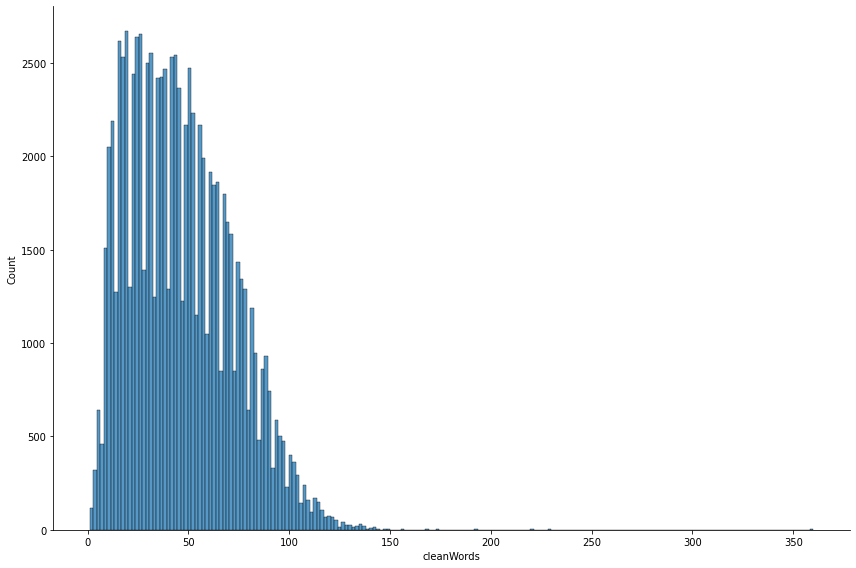

In [38]:
sns.displot(df_filtered.cleanWords,height=8,aspect=1.5)

In [49]:
df_filtered['cleanWords'].quantile(0.8)

69.0

In [50]:
max_len = 60


## Text Tokenization

In [51]:
tokenizer(text='So Dick , how about getting some coffee for tonight aaaaaaaaa kifech ?',
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding='max_length',
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                   )

{'input_ids': <tf.Tensor: shape=(1, 60), dtype=int32, numpy=
array([[  101,  2061,  5980,  1010,  2129,  2055,  2893,  2070,  4157,
         2005,  3892, 13360, 11057, 11057, 11057, 11382,  7959,  2818,
         1029,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 60), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>}

In [52]:
X_train = tokenizer(text=train_data.cleanText.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding='max_length',
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                   )

X_test = tokenizer(text=test_data.cleanText.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding='max_length',
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                  )

## Defining the model architecture

In [53]:
input_ids = Input(shape=(max_len,),name='input_ids',dtype=tf.int32)
attention_mask = Input(shape=(max_len,),name='attention_mask',dtype=tf.int32)

In [54]:
embeddings = bert_model(input_ids,attention_mask=attention_mask)[0] # 0: final hidden state, 1: pooling output
output = GlobalMaxPool1D()(embeddings)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.1)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=32,activation='relu')(output)
y = Dense(units=7,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=y)
model.layers[2].trainable = True

## Compiling the model

In [55]:
model.compile(loss=CategoricalCrossentropy(),
              optimizer=Adam(learning_rate=5e-5,epsilon=1e-8,decay=0.01,clipnorm=1.0),
              metrics=CategoricalAccuracy('balanced_accuracy'))

## Encoding the emotion labels

In [52]:
#train_data['Label'] = train_data.Sentiment.map(encoded_labels)
#test_data['Label'] = test_data.Sentiment.map(encoded_labels)

## Generating the model summary and plot

In [56]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 60)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_3 (TFBertModel)   TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           tf_bert_model_3[0][0]        

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


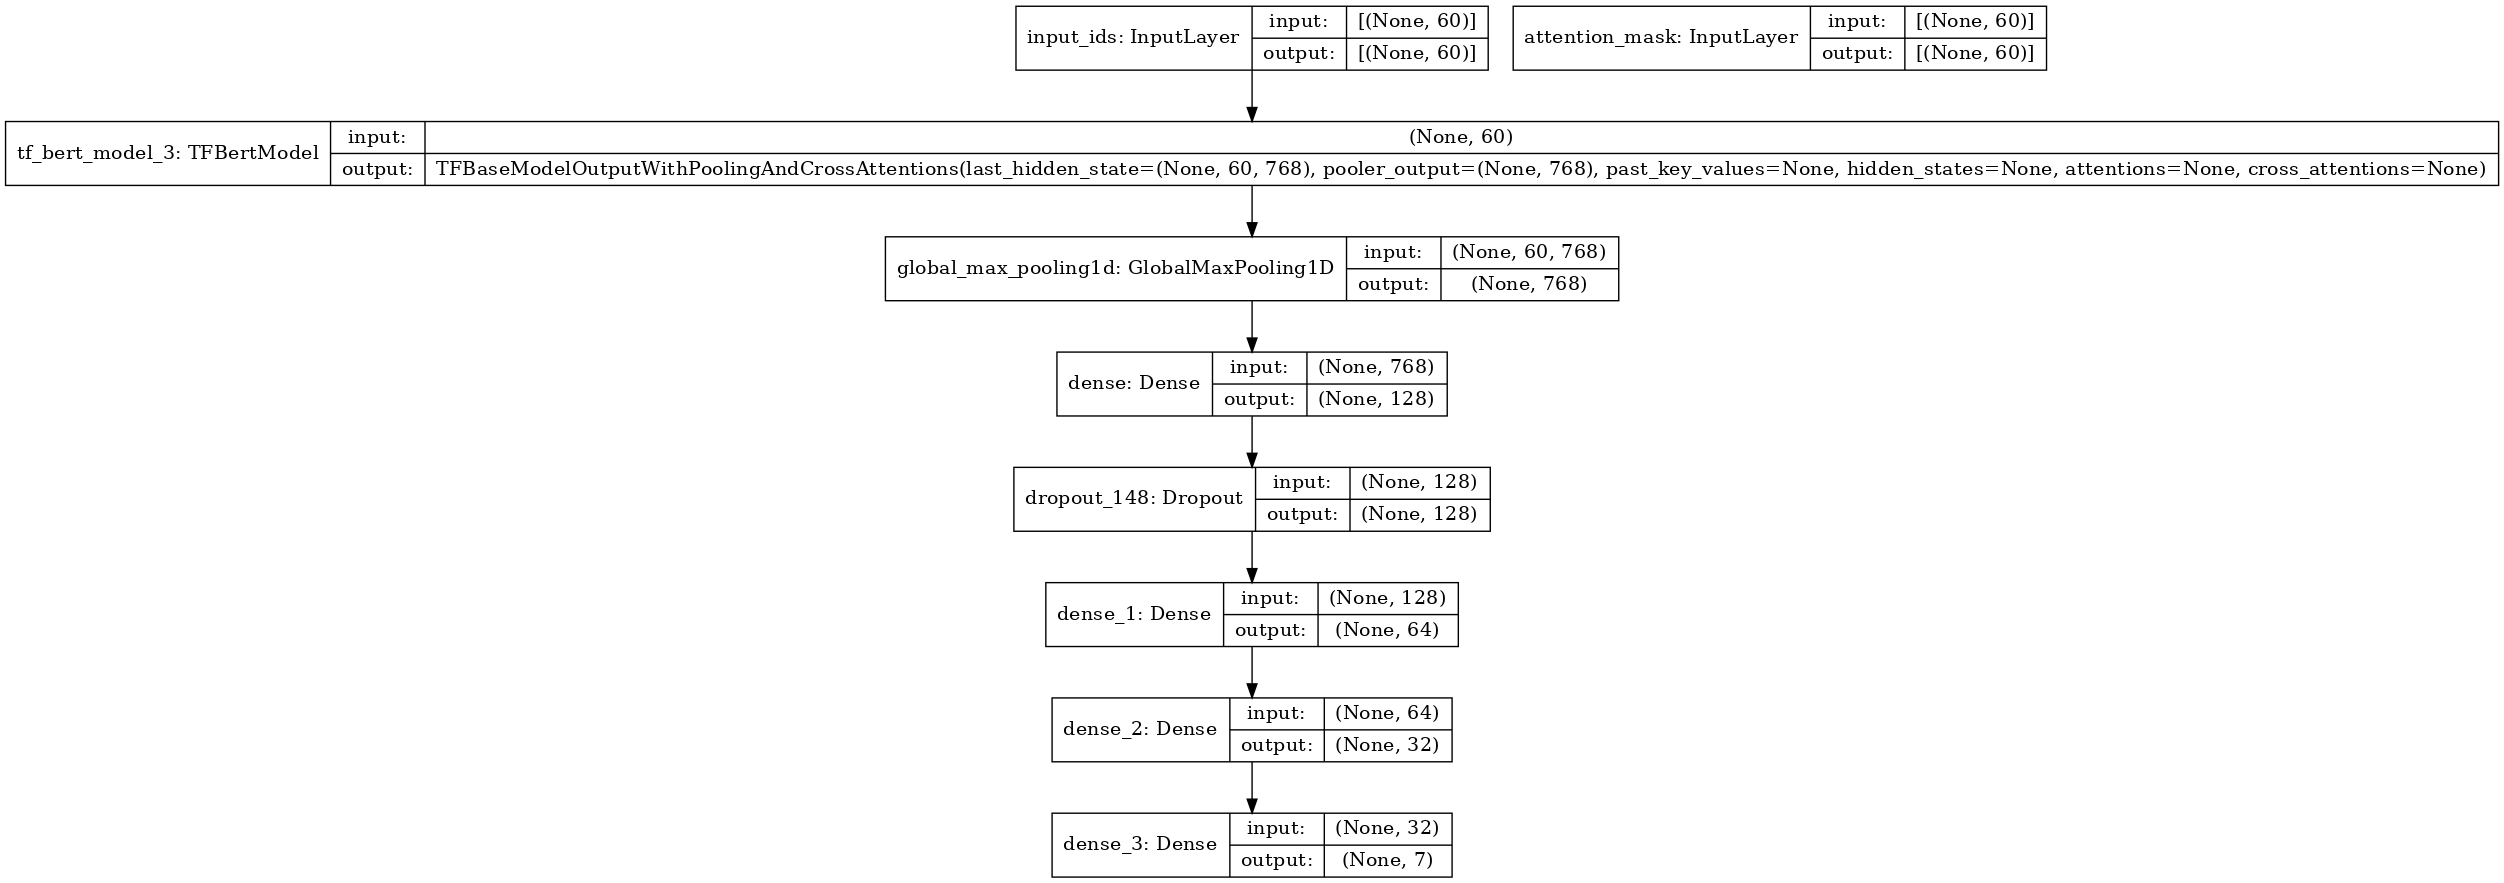

In [57]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

## Training and fine-tuning the pretrained BERT model 

In [58]:
X_train['input_ids'],X_train['attention_mask']

(<tf.Tensor: shape=(63429, 30), dtype=int32, numpy=
 array([[  101,  4569,  2755, ...,     0,     0,     0],
        [  101, 10166, 15640, ...,     0,     0,     0],
        [  101,  7459,  1010, ...,     0,     0,     0],
        ...,
        [  101,  2205,  2397, ...,     0,     0,     0],
        [  101,  2054,  9643, ...,     0,     0,     0],
        [  101, 17445,  2229, ...,     0,     0,     0]], dtype=int32)>,
 <tf.Tensor: shape=(63429, 30), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>)

In [41]:
to_categorical(test_data.label)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [58]:
def create_model_checkpoint(model_name, save_path="./model_checkpoints"):
  # create filepath to save model
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name+'.keras'),
                                            monitor="val_loss",
                                            verbose=0, 
                                            save_best_only=True)

In [59]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_balanced_accuracy',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

In [60]:
r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=to_categorical(train_data.label),
             epochs=10,
             batch_size=128,
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.label))
              ,callbacks = [early_stopping,
                  create_model_checkpoint(model_name=model.name)]
             
             ) 

Epoch 1/10
496/496 [==============================] - 1005s 2s/step - loss: 1.0391 - balanced_accuracy: 0.6727 - val_loss: 0.8886 - val_balanced_accuracy: 0.7061
Epoch 2/10
496/496 [==============================] - 982s 2s/step - loss: 0.8475 - balanced_accuracy: 0.7233 - val_loss: 0.8747 - val_balanced_accuracy: 0.7087
Epoch 3/10
496/496 [==============================] - 982s 2s/step - loss: 0.8094 - balanced_accuracy: 0.7345 - val_loss: 0.8653 - val_balanced_accuracy: 0.7111
Epoch 4/10
496/496 [==============================] - 982s 2s/step - loss: 0.7837 - balanced_accuracy: 0.7420 - val_loss: 0.8613 - val_balanced_accuracy: 0.7137
Epoch 5/10
496/496 [==============================] - 983s 2s/step - loss: 0.7689 - balanced_accuracy: 0.7468 - val_loss: 0.8654 - val_balanced_accuracy: 0.7097
Epoch 6/10
496/496 [==============================] - 981s 2s/step - loss: 0.7553 - balanced_accuracy: 0.7507 - val_loss: 0.8682 - val_balanced_accuracy: 0.7098
Restoring model weights from the 

In [61]:
encoded_labels = {
    'anger': 0,
    'disgust': 1, 
    'fear': 2,
    'happiness': 3,
    'sadness': 4,
    'surprise': 5,
    'neutral': 6
}
map_num2label = {v:k for k,v in encoded_labels.items()}

## Analyzing model performance

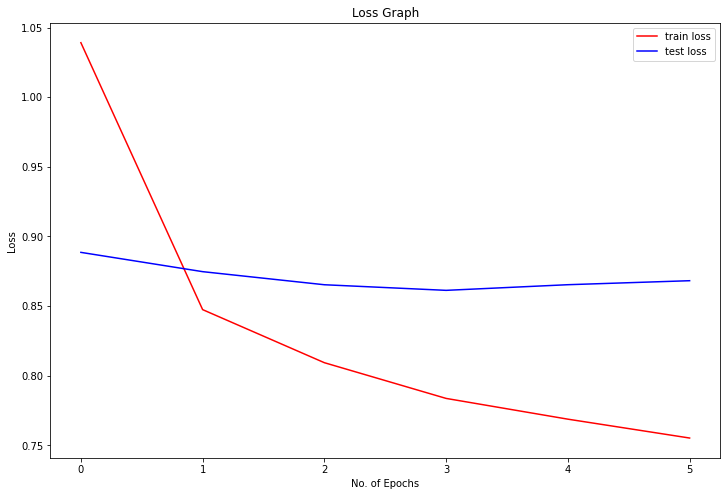

In [62]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

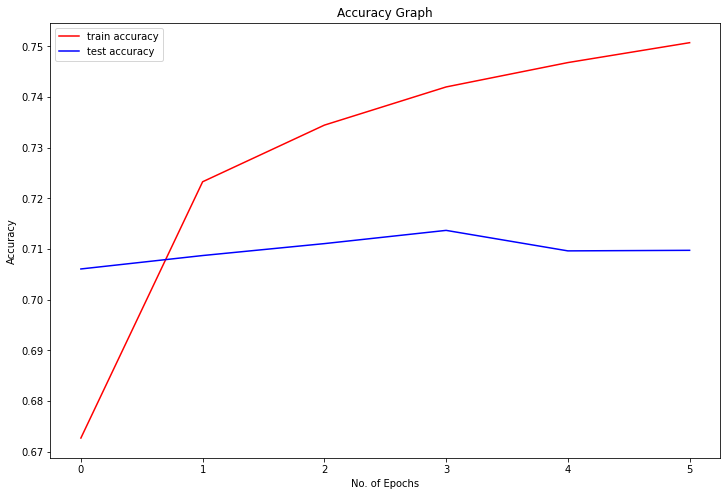

In [63]:
plt.figure(figsize=(12,8))
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Saving the model

In [ ]:
model.save("emotion_detector-v2.h5")

## Evaluating the model on the test dataset

In [63]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
print("Test Categorical Cross-Entropy Loss:",loss)
print("Test Categorical Accuracy:",acc)

19/19 [==============================] - 2s 95ms/step - loss: 0.4433 - balanced_accuracy: 0.8850
Test Categorical Cross-Entropy Loss: 0.44329503178596497
Test Categorical Accuracy: 0.8849999904632568


In [64]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print(classification_report(test_data.Label,test_predictions))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88        87
           1       0.94      0.79      0.86        73
           2       0.92      0.91      0.92       192
           3       0.81      0.64      0.72        53
           4       0.91      0.94      0.92       177
           5       0.68      0.94      0.79        18

    accuracy                           0.89       600
   macro avg       0.85      0.86      0.85       600
weighted avg       0.89      0.89      0.88       600



The result is quite promising as we've obtained an excellent f1-score of almost 80% for all the 6 emotion classes.

In [4]:
os.path.exists('/kaggle/working/emotion_detector.h5')

True

In [5]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Define the path to your saved model
model_path = "/kaggle/working/emotion_detector.h5"

# Load the model with the necessary custom objects
model = tf.keras.models.load_model(
    model_path,
    custom_objects={"TFBertModel": TFBertModel}
)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           tf_bert_model_1[0][0]        

In [1]:
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf
tokenizer = BertTokenizer.from_pretrained("/kaggle/working/tokenizer")
#tokenizer.save_pretrained('/kaggle/working/tokenizer')

In [7]:
map_labels = {
    6:"neutral",
    2:'Joy',
    0:"Anger",
    5:"Surprise",
    1:"fear",
    3:"Love",
    4:"sadness",
}

In [64]:
removeStopWords, punct, remove_, remove_special_characters, remove_digits

(<function helper_prabowo_ml.removeStopWords(str)>,
 <function helper_prabowo_ml.punct(text)>,
 <function helper_prabowo_ml.remove_(tweet)>,
 <function helper_prabowo_ml.remove_special_characters(text)>,
 <function helper_prabowo_ml.remove_digits(text)>)

In [74]:
max_len = 100
text = 'Go away you stupid'
def predict(model,tokenizer,text,max_len=60):
    text = removeStopWords(text)
    inputs = tokenizer(text,max_length=max_len,padding='max_length',truncation=True,return_tensors='tf',return_token_type_ids=False,
                       return_attention_mask=True,
                       verbose=True)
    preds = model.predict([inputs["input_ids"],inputs["attention_mask"]])
    predicted_classes = tf.argmax(preds, axis=1)
    print(map_num2label[predicted_classes[0].numpy()])
predict(model,tokenizer,text)

anger
